<h1 align="center"> Geometric Methods in ML - ENSAE 2016/2017 </h1>
<h2 align="center"> Kernels approximation with Random Features </h2>
<h4 align="right"> <i>Author: Hicham Janati </i></h4>


In this notebook, we reproduce all experiments of J. pennington et al., 2015. on USPS and Gisette datasets and produce the figures and tables of <a href="https://github.com/hichamjanati/srf/review.pdf"> our review </a>


In [1]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
%matplotlib inline 
from matplotlib import pyplot as plt 
import matplotlib as mpl
data = '../data/'

Import the KernelApprox and SRFF Classes implemented in <a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-I.ipynb"> SRF - Polynomial Kernel - Implementation I </a>  and <a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-II.ipynb"> SRF - Polynomial Kernel - Implementation II </a> 

In [2]:
from KernelApprox import*
from SRFF import*

# Experiments: 

#### Let's try to reproduce the experimental results of J. Pennington et al., 2015 on USPS and Gisette datasets. 

In [15]:
from sklearn.metrics.pairwise import  polynomial_kernel, linear_kernel
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

digits = fetch_mldata("USPS")
X_usps, y_usps = digits.data, digits.target.astype(int) - 1

X_gis = pd.read_csv(data + "gisette/X_train.txt",sep=' ',header=None).drop([5000],axis=1).values
y_gis = pd.read_csv(data + "gisette/y_train.txt",header=None).values.flatten()

mnist = fetch_mldata("MNIST original")
X_mnist, y_mnist = mnist.data, mnist.target.astype(int) - 1

print("USPS: X.shape = {} | y.shape = {} | number of classes : {}".format(X_usps.shape, y_usps.shape, len(np.unique(y_usps))))
print("Gisette: X.shape = {} | y.shape = {} | number of classes : {}".format(X_gis.shape, y_gis.shape, len(np.unique(y_gis))))
print("Mnist: X.shape = {} | y.shape = {} | number of classes : {}".format(X_mnist.shape, y_mnist.shape, len(np.unique(y_mnist))))


USPS: X.shape = (9298, 256) | y.shape = (9298,) | number of classes : 10
Gisette: X.shape = (6000, 5000) | y.shape = (6000,) | number of classes : 2
Mnist: X.shape = (70000, 784) | y.shape = (70000,) | number of classes : 10


### Fixed constants

In [4]:
A = 4
gamma = 2/A**2
coef0 = 1 - gamma
EPS, GRID_SIZE = 1e-20, 500
N = 10

As mentioned in the previous notebook, Gisette dataset is very high dimensional. ApproxKernel cannot handle dim>2049 (overflow). We project the data on 2049 PCA components.

In [5]:
from sklearn.decomposition import PCA
pca = PCA(2049)
X_gis_pca = pca.fit_transform(X_gis)

In [57]:
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from time import time

MAKE_EXPERIMENTS = 0
if MAKE_EXPERIMENTS:
    STATS = {}
    TIMES = {}
    n_repeats = 10
    Ps = [3,7,10,20]
    lPs = len(Ps)
    Ds = [2**i for i in range(6,15)]
    lDs = len(Ds)

    n_samples = 50000

    for (X,y,name) in zip([X_gis_pca,X_usps],[y_gis,y_usps],['Gisette','Usps']):
        print("DATASET: %s" %name)
        STATS[name] = {}
        STATS[name]['Exact'] = np.zeros(lPs)
        STATS[name]['MSE'] = np.zeros((lPs,lDs,n_repeats))
        STATS[name]['ACC'] = np.zeros((lPs,lDs,n_repeats))
        STATS[name]['CDF'] = []

        TIMES[name] = {}
        TIMES[name]['Exact'] = np.zeros(lPs)
        TIMES[name]['RFF'] = np.zeros((lPs,lDs,n_repeats))

        X,y = X[:n_samples].copy(), y[:n_samples].copy()
        X_normalization = np.sqrt((X * X).sum(axis=1))
        Xnorm = X/X_normalization.reshape(-1,1)
        DIM = Xnorm.shape[1]
        skf = ShuffleSplit(n_splits=2, test_size=0.3, random_state=123)  
        train_is, test_is = list(skf.split(Xnorm))[0]
        X_train = Xnorm[train_is].copy()                                  
        y_train = y[train_is].copy()
        X_test = Xnorm[test_is].copy()                                    
        y_test = y[test_is].copy() 

        for i,P in enumerate(Ps):
            print("--> P= %s" %P)
            def polynomial_kernel_scalar(z, a = A, degree = P):
                return (1- (z/a)**2)**degree

            K_true = polynomial_kernel(Xnorm, gamma = gamma, degree = P, coef0 = coef0)

            while(True):
                Kapp = KernelApprox(dim = DIM, verbose = False, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = N)
                Kapp.fit(eval_grid_factor=2)
                z = np.linspace(0,2,2*GRID_SIZE)
                if ((polynomial_kernel_scalar(z) - Kapp.get_kernel_approx())**2).mean()<1e-2:
                    break
            cdf = Kapp.get_cdf()
            STATS[name]['CDF'].append(cdf)

            exact_svm = OneVsRestClassifier(SVC(C=1, kernel="poly", coef0 = coef0, degree = P, gamma=gamma))

            t = time()
            exact_svm.fit(X_train,y_train)
            TIMES[name]['Exact'][i] = time() - t

            y_pred = exact_svm.predict(X_test)                      
            acc = accuracy_score(y_test, y_pred) 
            STATS[name]['Exact'][i] = acc

            print("Exact accuracy: %s " %acc)
            for j,D in enumerate(Ds):
                srff_pip = Pipeline([
                    ('srff',SRFF(cdf, a = A, p = P, D = D )),
                    ('linsvc', OneVsRestClassifier(LinearSVC(C=1))),
                 ])
                for k in range(n_repeats):
                    t = time()
                    srff_pip.fit(X_train, y_train)
                    TIMES[name]['RFF'][i,j,k] = time() - t

                    K_approx = srff_pip.named_steps['srff'].compute_kernel(Xnorm)
                    mse = ((K_true - K_approx)**2).mean()
                    STATS[name]['MSE'][i,j,k] = mse

                    y_pred_srff = srff_pip.predict(X_test)                      
                    acc = accuracy_score(y_test, y_pred_srff)
                    STATS[name]['ACC'][i,j,k] = acc
            print("Best RFF acc: %s", STATS[name]['ACC'][i].max())
            
            np.save(data+"STATS",STATS)
            np.save(data+"TIMES",TIMES)
else:
    STATS = np.load(data+"STATS.npy")
    STATS = STATS.tolist()
    
    TIMES = np.load(data+"TIMES.npy")
    TIMES = TIMES.tolist()

DATASET: Gisette
--> P= 3
Exact accuracy: 0.965555555556 
Best RFF acc: %s 0.971111111111
--> P= 7
Exact accuracy: 0.971111111111 
Best RFF acc: %s 0.973333333333
--> P= 10
Exact accuracy: 0.973888888889 
Best RFF acc: %s 0.973333333333
--> P= 20
Exact accuracy: 0.972222222222 
Best RFF acc: %s 0.967777777778
DATASET: Usps
--> P= 3
Exact accuracy: 0.932616487455 
Best RFF acc: %s 0.95017921147
--> P= 7
Exact accuracy: 0.952688172043 
Best RFF acc: %s 0.966308243728
--> P= 10
Exact accuracy: 0.960215053763 
Best RFF acc: %s 0.973476702509
--> P= 20
Exact accuracy: 0.97311827957 
Best RFF acc: %s 0.978136200717


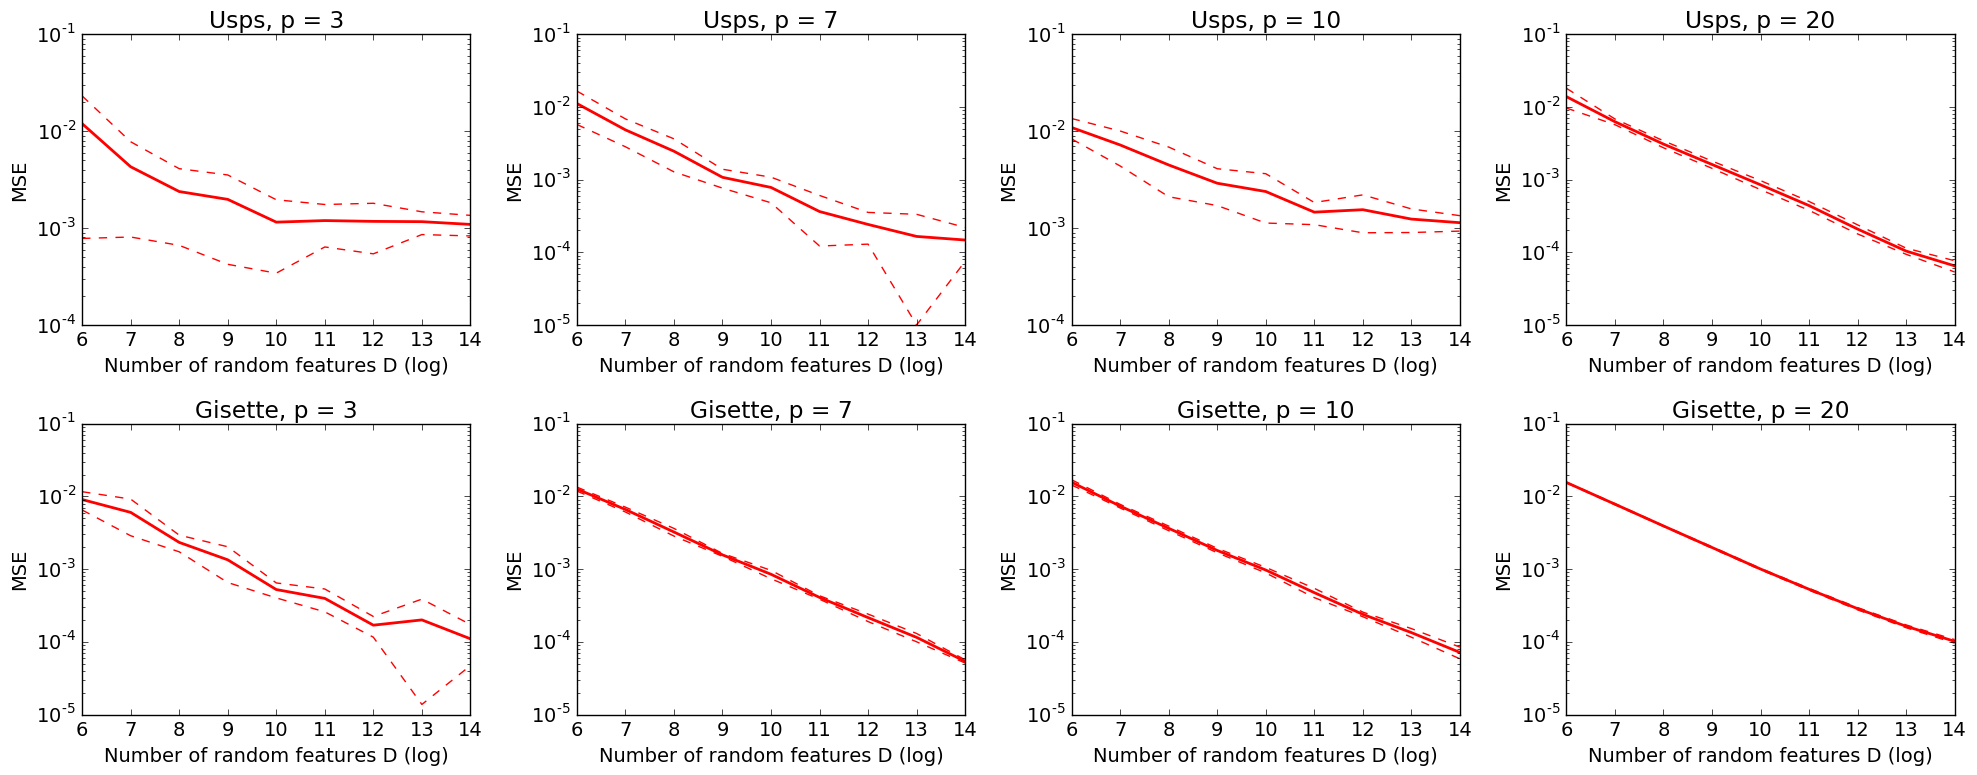

In [131]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages("srff_mse.pdf")
mpl.rcParams.update({'font.size': 14})
logDs = np.arange(6,15)
f = plt.figure(figsize=(20,8))
k = 0
for i,name in enumerate(['Usps','Gisette']):
    mse_data = STATS[name]['MSE']
    for j,p in enumerate(Ps):
        k += 1
        plt.subplot(2,lPs,k)
        mean = mse_data[j].mean(axis=-1)
        std = mse_data[j].std(axis=-1)
        plt.plot(logDs,mean, 'r', linewidth=2, label="SRF")
        plt.plot(logDs,mean+std, 'r--')
        plt.plot(logDs,np.clip(mean-std,1e-5,None), 'r--') #avoid a negative mean-std stat (usps,7)
        plt.yscale("log")
        plt.ylabel("MSE")
        plt.xlabel("Number of random features D (log)")
        plt.xlim([logDs[0],logDs[-1]])
        plt.title("{}, p = {}".format(name,p))
        
plt.tight_layout()
pp.savefig(f)
pp.close()
plt.show()

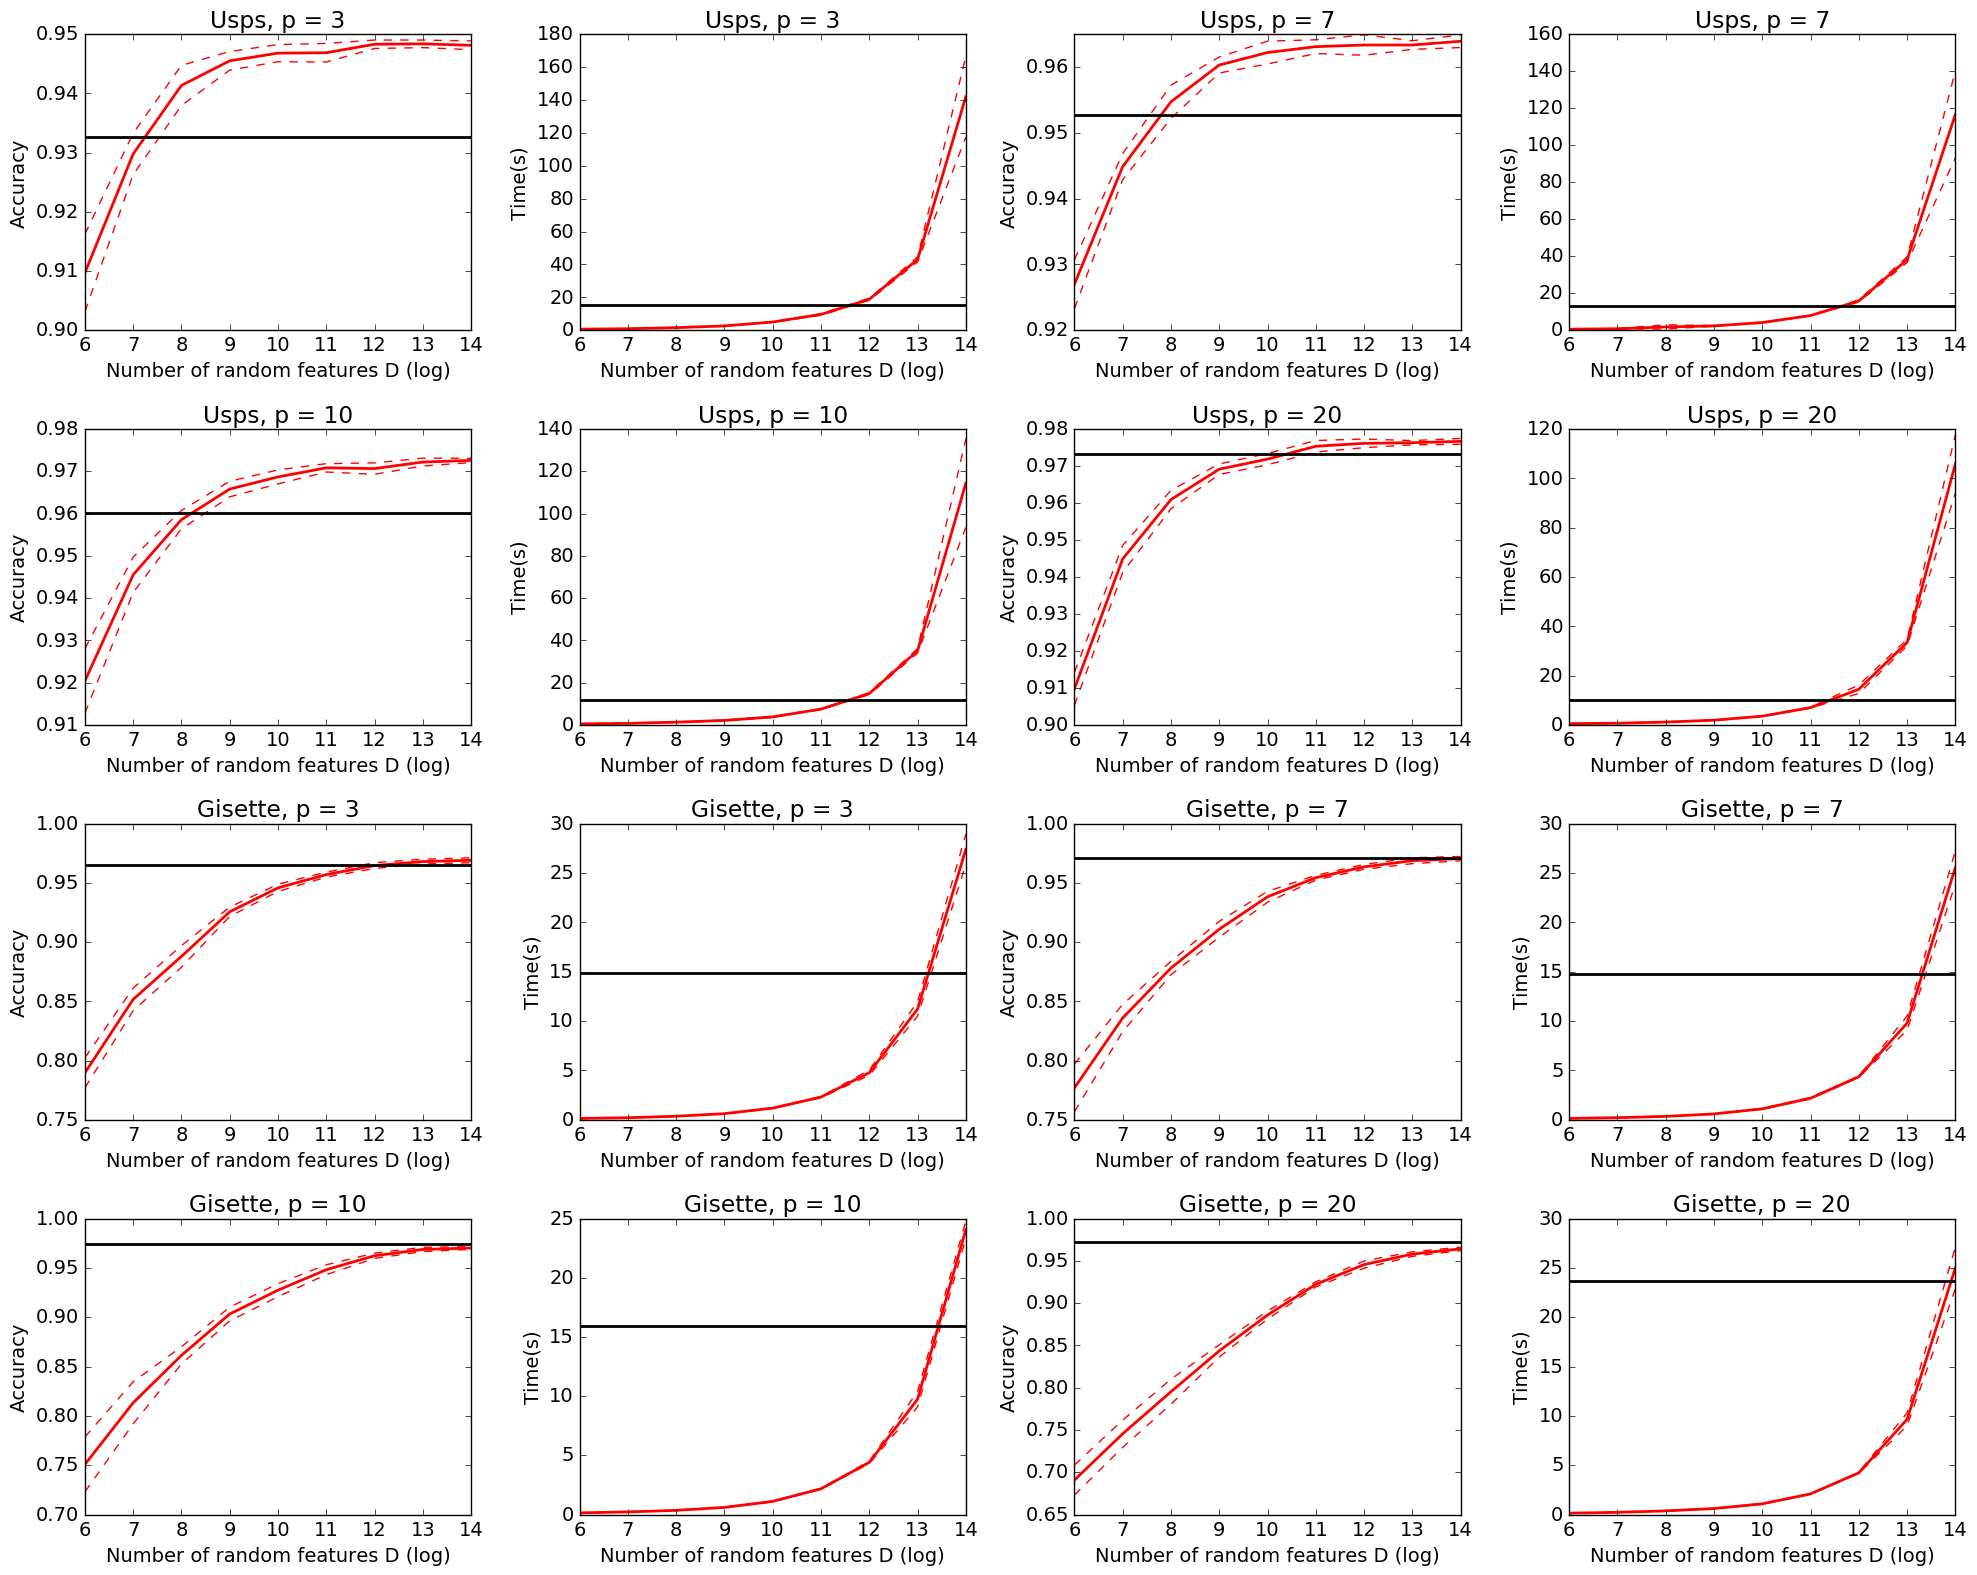

In [130]:
pp = PdfPages("srff_svm.pdf")
mpl.rcParams.update({'font.size': 14})
logDs = np.arange(6,15)
f = plt.figure(figsize=(20,16))
k = 0
for i,name in enumerate(['Usps','Gisette']):
    mse_data = STATS[name]['ACC']
    mse_exact = STATS[name]['Exact']
    time_data = TIMES[name]['RFF']
    time_exact = TIMES[name]['Exact']
    for j,p in enumerate(Ps):
        k += 1
        plt.subplot(4,lPs,k)
        mean = mse_data[j].mean(axis=-1)
        std = mse_data[j].std(axis=-1)
        plt.plot(logDs,mean, 'r', linewidth=2, label="SRF")
        plt.plot(logDs,mean+std, 'r--')
        plt.plot(logDs,mean-std, 'r--') 
        plt.plot(logDs,lDs*[mse_exact[j]], 'k', linewidth=2, label="Exact")
        plt.ylabel("Accuracy")
        plt.xlabel("Number of random features D (log)")
        plt.xlim([logDs[0],logDs[-1]])
        plt.title("{}, p = {}".format(name,p))
        
        k +=1
        plt.subplot(4,lPs,k)
        mean = time_data[j].mean(axis=-1)
        std = time_data[j].std(axis=-1)
        plt.plot(logDs,mean, 'r', linewidth=2, label="SRF")
        plt.plot(logDs,mean+std, 'r--')
        plt.plot(logDs,mean-std, 'r--') 
        plt.plot(logDs,lDs*[time_exact[j]], 'k', linewidth=2, label="Exact")
        plt.ylabel("Time(s)")
        plt.xlabel("Number of random features D (log)")
        plt.xlim([logDs[0],logDs[-1]])
        plt.title("{}, p = {}".format(name,p))
        
#plt.legend(bbox_to_anchor = [-1.3,5.55], fontsize=15)
plt.tight_layout()
pp.savefig(f)
pp.close()
plt.show()

## LaTeX tables code ... 

In [195]:
s = ""
for i,name in enumerate(['Usps','Gisette']):
    mse_data = STATS[name]['ACC']
    mse_exact = STATS[name]['Exact']
    time_data = TIMES[name]['RFF']
    time_exact = TIMES[name]['Exact']
    #s += name.capitalize() + " &"
    for j,p in enumerate(Ps):
        s += " p = {} Accuracy& ".format(p)
        mean = mse_data[j].mean(axis=-1)
        std = mse_data[j].std(axis=-1)
        meant = time_data[j].mean(axis=-1)
        stdt = time_data[j].std(axis=-1)
        
        for D in range(9,15):
            s += str(np.round(100*mean[D-8],2)) + r'$\%  \pm$ ' + str(np.round(100*std[D-8],2)) + " & "
        
        s += str(np.round(100*mse_exact[j],2))
        s += r" \\ "

        s += "Time in s & ".format(p)


        for D in range(9,15):
            s += str(np.round(100*meant[D-8],2)) + r'$s \, \pm$ ' + str(np.round(100*stdt[D-8],2)) + " & "
        
        s += str(np.round(100*time_exact[j],2))
        s += r" \\  \hline "
    
    s += "\n ----------------------------------------\n"
        
print(s)

 p = 3 Accuracy& 92.98$\%  \pm$ 0.35 & 94.14$\%  \pm$ 0.34 & 94.55$\%  \pm$ 0.16 & 94.68$\%  \pm$ 0.15 & 94.69$\%  \pm$ 0.16 & 94.83$\%  \pm$ 0.07 & 93.26 \\ Time in s & 92.71$s \, \pm$ 6.51 & 158.02$s \, \pm$ 11.46 & 263.47$s \, \pm$ 6.61 & 500.93$s \, \pm$ 15.5 & 962.58$s \, \pm$ 47.03 & 1883.07$s \, \pm$ 59.01 & 1546.57 \\  \hline  p = 7 Accuracy& 94.49$\%  \pm$ 0.2 & 95.47$\%  \pm$ 0.25 & 96.03$\%  \pm$ 0.12 & 96.22$\%  \pm$ 0.17 & 96.31$\%  \pm$ 0.1 & 96.34$\%  \pm$ 0.16 & 95.27 \\ Time in s & 81.51$s \, \pm$ 11.31 & 179.49$s \, \pm$ 115.64 & 234.12$s \, \pm$ 15.07 & 416.62$s \, \pm$ 16.39 & 793.27$s \, \pm$ 14.07 & 1582.71$s \, \pm$ 57.32 & 1289.43 \\  \hline  p = 10 Accuracy& 94.55$\%  \pm$ 0.42 & 95.86$\%  \pm$ 0.22 & 96.58$\%  \pm$ 0.18 & 96.87$\%  \pm$ 0.17 & 97.08$\%  \pm$ 0.1 & 97.06$\%  \pm$ 0.13 & 96.02 \\ Time in s & 77.91$s \, \pm$ 12.84 & 134.0$s \, \pm$ 10.96 & 214.82$s \, \pm$ 19.92 & 383.55$s \, \pm$ 24.26 & 751.5$s \, \pm$ 18.58 & 1488.49$s \, \pm$ 47.46 & 1160.42 

In [205]:
s = "Dataset "
for i in range(8,15):
    s += " & $ D = 2^{}".format(i)
s

'Dataset  & $ D = 2^8 & $ D = 2^9 & $ D = 2^10 & $ D = 2^11 & $ D = 2^12 & $ D = 2^13 & $ D = 2^14'